In [38]:
# %load_ext autoreload
# %autoreload 2

In [39]:

import os
import random
import time
import datetime
import sys
import json

import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import matplotlib.ticker as ticker

os.chdir('./')
# EdMIPS/models ディレクトリへのパスを追加
sys.path.append('./models')
from models.quant_efficientnet import BasicCNNBlock
import models as models

# カレントディレクトリを 'EdMIPS' に変更
os.chdir('.')

PLOT_LINESTYLES = ['-', '--', '-.', ':']
PLOT_MARKERS = ['o', 'v', 'P', 'X', 'D', '^', 's']
FIGURE_SIZE = (15, 5)

In [40]:
device_count = torch.cuda.device_count()
print('Number of devices: {}'.format(device_count))
# setting device
device = torch.device(f'cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'is GPU avilable? :{torch.cuda.is_available()}')
cudnn.benchmark = True

Number of devices: 2
is GPU avilable? :True


In [41]:
def validate(val_loader, model, criterion):
    acc1_avg = 0
    acc5_avg = 0
    # switch to evaluate mode
    model.eval()
    model.to(device)

    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate(val_loader):
            images = images.to(device)
            target = target.to(device)
            
            # cifar-10のみ
            images = F.interpolate(images,size=(224,224),mode='bicubic')
            # compute output
            output = model(images)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            acc1_avg += float(acc1)
            acc5_avg += float(acc5)
            # check
            # print(f'{i}  acc1:{int(acc1)}  acc5:{int(acc5)}')


        
    acc1_avg = acc1_avg / len(val_loader)
    acc5_avg = acc5_avg / len(val_loader)
    return acc1_avg , acc5_avg
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            #correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [42]:
def load_cifar10(batch):
    train_loader = DataLoader(
        datasets.CIFAR10('./data',
                         train=True,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                [0.5, 0.5, 0.5],  # RGB 平均
                                [0.5, 0.5, 0.5]   # RGB 標準偏差
                                )
                         ])),
        batch_size=batch,
        shuffle=True
    )

    val_loader = DataLoader(
        datasets.CIFAR10('./data',
                         train=False,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                 [0.5, 0.5, 0.5],  # RGB 平均
                                 [0.5, 0.5, 0.5]  # RGB 標準偏差
                             )
                         ])),
        batch_size=batch,
        shuffle=False
    )

    return train_loader,val_loader

def load_cifar100(batch):
    train_loader = DataLoader(
        datasets.CIFAR100('./data',
                         train=True,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                [0.5, 0.5, 0.5],  # RGB 平均
                                [0.5, 0.5, 0.5]   # RGB 標準偏差
                                )
                         ])),
        batch_size=batch,
        shuffle=True
    )

    val_loader = DataLoader(
        datasets.CIFAR100('./data',
                         train=False,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                 [0.5, 0.5, 0.5],  # RGB 平均
                                 [0.5, 0.5, 0.5]  # RGB 標準偏差
                             )
                         ])),
        batch_size=batch,
        shuffle=True
    )

    return train_loader,val_loader

def load_imagenet100(DATASETDIR,config):
    # Data loading code
    traindir = os.path.join(DATASETDIR, 'train')
    valdir = os.path.join(DATASETDIR , 'val')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

    crop_size, short_size = 224, 256


    train_dataset = datasets.ImageFolder(
        traindir,
        transforms.Compose([
            transforms.RandomResizedCrop(crop_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))
    print(f'crop size:{crop_size},short_size:{short_size}')
    train_sampler = None

    train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=config['batch_size'], shuffle=(train_sampler is None),
        num_workers=config['workers'], pin_memory=True, 
        sampler=train_sampler)

    val_dataset =datasets.ImageFolder(
        valdir,
        transforms.Compose([
            transforms.Resize(short_size),
            transforms.CenterCrop(crop_size),
            transforms.ToTensor(),
            normalize,
        ]))
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=config['batch_size'], shuffle=False,
        num_workers=config['workers'], pin_memory=True)

    # print(len(train_loader))
    # print(len(val_loader))
    return train_loader,val_loader

In [43]:
def find_B(train_loader,model,splitting_points):
    model.to(device)
    model.change_learning_method(False)
    with torch.no_grad():
        for i, (images, target) in enumerate(train_loader):
            images = images.to(device)
            # cifar-10のみ
            images = F.interpolate(images,size=(224,224),mode='bicubic')
            model.eval()
            if i==0:
                features_list = torch.stack(model.feature_extractor(images,splitting_points))
            else:
                features = torch.stack(model.feature_extractor(images,splitting_points))
                features_list = torch.cat([features_list,features],dim = 1)
    # check
    print([len(v) for v in features_list])
    
    
    bound_threshold_medi = torch.median(features_list,dim = 1).values
    bound_threshold_mean = torch.mean(features_list,dim = 1)
    
    # check 
    print(f"bound threshold median : {bound_threshold_medi}")
    print(f"bound threshold mean : {bound_threshold_mean}")

    return bound_threshold_medi

In [44]:
def get_natural_bottlenecks(model, input_size, act_bits, compressive_only=True):
    # 各層のinputサイズを計算して、圧縮率が最も高い層を探す
    natural_bottlenecks = []
    best_compression = 1.0
    cnn_count = 0  # CNNレイヤーのカウント
    input_bit = 8 # 入力のbit数
    min_bit = 8  # 探索する最小のbit数←使って無くない？
    bit_compression = [act_bit / input_bit for act_bit in act_bits]

    device = next(model.parameters()).device
    
    mock_input = torch.randn(1, 3, input_size, input_size).to(device)
    previous_size = torch.prod(torch.tensor(mock_input.shape[1:])).item()

    for i, module in enumerate(model.features):
        
        block_number = i-1 # 0はfeaturesの最初のBasicCNNBlockなので、1から始める
        # print(i,block_number, module)
        if isinstance(module, BasicCNNBlock):
            print(f"Encountered BasicBlock at features.{i}")
            output = module(mock_input)
            mock_input = output.detach()
            continue
        
        input_size_layer = torch.prod(torch.tensor(mock_input.shape[1:])).item()
        if input_size_layer * act_bits[cnn_count] < input_size * input_size * 3 * input_bit:
            compression = float(input_size_layer) / (input_size * input_size * 3)
            compression *= bit_compression[cnn_count]
            if not compressive_only or compression < best_compression:
                natural_bottlenecks.append({
                    'layer_name': "blocks_{}".format(block_number),
                    'compression': compression,
                    'cnn_layer_number': cnn_count,  # ここでCNNレイヤーの番号を記録
                    'block_number': block_number,  
                })
                best_compression = compression
        output = module(mock_input)
        mock_input = output.detach()
        
        cnn_count += count_conv2d_layers(module)
        # check
        # print(i,block_number, cnn_count)
    return natural_bottlenecks

def count_conv2d_layers(model):
    count = 0
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            count += 1
        elif isinstance(module, nn.Sequential):
            # Sequentialブロック内でさらにConv2dを探す
            for sub_module in module:
                if isinstance(sub_module, nn.Conv2d):
                    count += 1
    return count

In [45]:
def load_batch_table():
    batch_table_path = 'batch_table/efficient_baseline_v5.json'    # b0
    # batch_table_path = 'batch_table/efficientb3_baseline_v10.json'   #b3
    with open(batch_table_path, 'r') as batch_table_file:
        return json.loads(batch_table_file.read())
# ベースラインのバッチテーブルからバッチテーブルのキーがwhole_deviceとwhole_edgeであるデータと、natural_bottlenekとなる
# ブロックのデータを抜き出し、natural_bottlenekとなるブロックのcompressionの値を get_natural_bottlenecks()で求めた別のモデルのcompressionの値に更新
def get_items_for_values(dictionary, whole_device, whole_edge, natural_bottlenecks):
    # natural_bottlenecksから分割点のblockのみ抜き出してリスト化
    target_keys = [split_point['layer_name'] for split_point in natural_bottlenecks]
    key_len = len(dictionary)
    new_dict = {}
    for i in range(1, key_len+1):
        new_dict[str(i)] = {}
        for key, value in dictionary[str(i)].items():
            if key in "whole_device" and whole_device:
                new_dict[str(i)][key] = value
            if key in "whole_edge" and whole_edge:
                new_dict[str(i)][key] = value
            if key in target_keys:
                new_dict[str(i)][key] = value
                # new_dict[str(i)][key]['compression'] = 0
                for natural in natural_bottlenecks:
                    if natural['layer_name'] == key:
                        new_dict[str(i)][key]['compression'] = natural['compression']
    return new_dict

In [ ]:
# 量子化しても送る時のbit幅は変わらない→量子化しても通信時間は変わらない
def get_load(compression, batch_size, config, full_offloading):
    # 3 channels
    load = batch_size * (config['image_size'] ** 2) * 3 * compression
    if not full_offloading:
        # load *= 4  # float32
        load *= 1 # int8をデフォルトに
    return load

def fix_legend_name(name):
    if name == 'whole_device':
        return 'No Offloading'
    elif name == 'whole_edge':
        return 'Full Offloading'
    else:
        # return 'Split at\n%s' % name.split('/')[-1]
        return name
def create_inference_plots(batch_table, config, acc_list,acc_baseline,create_individual=False,save_flag=True):
    split_points = list(batch_table[list(batch_table.keys())[0]].keys()) #←なにこれ？
    print(split_points)
    acc_list.insert(0,acc_baseline)
    bandwidths = np.arange(config['min_bandwidth'], config['max_bandwidth'], config['bandwidth_step'])
    best_splits_baseline ={}
    best_splits = {}
    gains = {}
    inference_times__all = []
    metrics_list__all = []
    for batch_size in batch_table.keys():
        if create_individual:
            plt.figure(figsize=FIGURE_SIZE)
        entry = batch_table[batch_size]
        inference_times_list = []
        metrics_list =[]
        
        for i, split_point in enumerate(split_points):
            if split_point == 'whole_device':
                inference_times = np.repeat(entry[split_point], bandwidths.shape[0]) 
                if create_individual:
                    plt.ylim(0, entry[split_point] * 2)
            elif split_point == 'whole_edge':
                load = get_load(1, int(batch_size), config, True)
                inference_times = entry[split_point] + load / bandwidths * 1000  # in milliseconds
            else:
                load = get_load(entry[split_point]['compression'], int(batch_size), config, False)
                inference_times = entry[split_point]['head'] + entry[split_point]['tail'] + load / bandwidths * 1000  # in milliseconds
            linestyle = PLOT_LINESTYLES[i % len(PLOT_LINESTYLES)]
            
            inference_times_list.append(inference_times)
            # calculation of metrics
            metrics = inference_times/entry['whole_device'] + (acc_baseline-acc_list[i])/acc_baseline
            metrics_list.append(metrics)
            # check
            # print(inference_times/entry['whole_device'])
            if create_individual:
                plt.plot(
                    bandwidths / 10 ** 6,
                    inference_times,
                    label=fix_legend_name(split_point),
                    linestyle=linestyle
                )
                
        # print(f'scaled inference time ,batch_size : {batch_size}')
        # for i in range(len(split_points)):
        #     print(f' split point : {split_points[i]}')
        #     print(f' inference time : {inference_times[i]},')
        #     print(f" baseline inference time(whole edge) : {entry['whole_device']}")
            # print(f" scaled inference time : {inference_times/entry['whole_device']}")
        
        best_split_baseline = np.argmin(np.array(inference_times_list), axis=0)
        best_split = np.argmin(np.array(metrics_list), axis=0)        
        
        best_splits_baseline[batch_size]=best_split_baseline
        best_splits[batch_size] = best_split
        
        inference_times__all.append(np.min(np.array(inference_times_list), axis=0))
        metrics_list__all.append(np.min(np.array(metrics_list), axis=0))
    
    
    total_points = 0
    useful_split_points = 0
    color_mapped_values = []
    plt.figure(figsize=FIGURE_SIZE)
    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    # 確認
    # print(split_points)
    # print(best_splits)
    
    for batch_size, best_split in sorted(best_splits.items(), key=lambda x: int(x[0])):
        color_mapped_values.append([])
        for bandwidth_index, entry in enumerate(best_split):
            for split_point_index, split_point in enumerate(split_points):
                if entry == split_point_index:
                    color_mapped_values[-1].append(split_point_index)
                    total_points += 1
                    # print(split_point)
                    if split_point != 'whole_edge' and split_point != 'whole_device':
                        useful_split_points += 1
                    break
    print(color_mapped_values)
    used_split_indices = np.sort(np.unique(np.array(color_mapped_values))).tolist()
    # print(used_split_indices)
    used_colors = [PLOT_COLORS[used_split_index] for used_split_index in used_split_indices]
    # print(used_colors)
    color_map = ListedColormap(used_colors)
    # print(color_map)

    # replace distinct values with their index of discovery
    previous_shape = np.array(color_mapped_values).shape
    _, color_mapped_values = np.unique(np.array(color_mapped_values), return_inverse=True)
    color_mapped_values = np.reshape(color_mapped_values, previous_shape)
    # colormesh = plt.pcolormesh(color_mapped_values, cmap=color_map)
    colormesh = plt.pcolormesh(color_mapped_values, cmap=color_map, edgecolors='w', linewidth=0.5)
    # legend
    cbar = plt.colorbar(colormesh)
    cbar.ax.get_yaxis().set_ticks([])
    max_value = np.amax(color_mapped_values)
    for j, used_split_index in enumerate(used_split_indices):
        cbar.ax.text(
            1.2,  # カラーバーからの相対位置
            j / len(used_split_indices) + 0.5 / len(used_split_indices),
            fix_legend_name(split_points[used_split_index]),
            ha='left',
            va='center',
            transform=cbar.ax.transAxes  
        )
    #################################################
    plt.xlabel('Data Rate (MBps)')
    plt.ylabel('Batch Size')
    # plt.title(r'(c) Ours ($\lambda = 1 \times 10^{-4}$)', fontsize=25, weight="bold")
    plt.title(config["graph_title"]+'  Noise Scale:'+str(config["noise_scale"]), fontsize=15, weight="bold")
    # save_path = os.path.join(INFERENCE_PLOT_DIR, '%s_all_%s_v%d.svg' % (
    #     config['model_name'],
    #     config['processors']['weak'].replace('/', ''),
    # ))
    if save_flag == True:
        save_path = f'{config["save_dir"]}/ours_all_noise-{config["noise_scale"]}.png'
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    # plt.close()
    
    
    
    # baseline
    print('baseline')
    color_mapped_values_baseline = []
    plt.figure(figsize=FIGURE_SIZE)
    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    # 確認
    # print(split_points)
    # print(best_splits)
    
    for batch_size, best_split in sorted(best_splits_baseline.items(), key=lambda x: int(x[0])):
        color_mapped_values_baseline.append([])
        for bandwidth_index, entry in enumerate(best_split):
            for split_point_index, split_point in enumerate(split_points):
                if entry == split_point_index:
                    color_mapped_values_baseline[-1].append(split_point_index)

                    break
    # print(color_mapped_values_baseline)
    used_split_indices = np.sort(np.unique(np.array(color_mapped_values_baseline))).tolist()
    # print(used_split_indices)
    used_colors = [PLOT_COLORS[used_split_index] for used_split_index in used_split_indices]
    # print(used_colors)
    color_map = ListedColormap(used_colors)
    # print(color_map)

    # replace distinct values with their index of discovery
    previous_shape = np.array(color_mapped_values_baseline).shape
    _, color_mapped_values = np.unique(np.array(color_mapped_values_baseline), return_inverse=True)
    color_mapped_values = np.reshape(color_mapped_values_baseline, previous_shape)
    # colormesh = plt.pcolormesh(color_mapped_values, cmap=color_map)
    colormesh = plt.pcolormesh(color_mapped_values_baseline, cmap=color_map, edgecolors='w', linewidth=0.5)
    # legend
    cbar = plt.colorbar(colormesh)
    cbar.ax.get_yaxis().set_ticks([])
    max_value = np.amax(color_mapped_values)
    for j, used_split_index in enumerate(used_split_indices):
        cbar.ax.text(
            1.2,  # カラーバーからの相対位置
            j / len(used_split_indices) + 0.5 / len(used_split_indices),
            fix_legend_name(split_points[used_split_index]),
            ha='left',
            va='center',
            transform=cbar.ax.transAxes,
            fontsize = 22
        )
    #################################################
    plt.xlabel('Data Rate (MBps)',fontsize = 22)
    plt.ylabel('Batch Size',fontsize = 22  )
    plt.xticks(fontsize=20) 
    plt.yticks(fontsize=18)
    # plt.title(r'(c) Ours ($\lambda = 1 \times 10^{-4}$)', fontsize=25, weight="bold")
    # plt.title('baseline : decide split point used only latency', fontsize=15, weight="bold")
    plt.show()
    


In [47]:
def set_seed(seed):
    random.seed(seed)                  # Pythonの乱数
    np.random.seed(seed)              # NumPyの乱数
    torch.manual_seed(seed)           # PyTorchのCPU乱数
    torch.cuda.manual_seed(seed)      # PyTorchのGPU乱数
    torch.cuda.manual_seed_all(seed)  # マルチGPUのための乱数
    torch.backends.cudnn.deterministic = True  # 再現性確保のための設定
    torch.backends.cudnn.benchmark = False     # パフォーマンス向上を無効化

In [48]:
config = {
    'model_name': 'quanteffnet_w8a8_with_DP',
    # 量子制度決定済み・何かしら学習したあとのアーキテクチャ
    'arch_path' : './privacy_aware_dsc/efficient_b0_w8a8/r_clean_25ep_noise_5_ep25_cifar10_v2/r_clean_25ep_noise_5_ep25_cifar10.pth.tar',
    'image_size': 224,
    'batch_sizes': list(range(1, 31)),
    'max_bandwidth': 64 * 10 ** 6,  # Bytes per second
    'min_bandwidth': 1 * 10 ** 6,  # Bytes per second
    'bandwidth_step': 1 * 10 ** 6,  # Bytes per second
    'batch_table_path':'./batch_table/efficient_baseline_v5.json',
    'batch_size': 50,
    'workers'   : 16,
    'noise_scale':5,
    'graph_title':'ours : decide split point used latency and accuracy',
    'save_dir': './privacy_aware_dsc/efficient_b0_w8a8/r_clean_25ep_noise_5_ep25_cifar10_v2',
}
DATASETDIR ='~/datasets/imagenet-100'
# 量子精度は決定したけど学習してないアーキテクチャ
mixefnet_dir=''
torch.backends.cudnn.deterministic = True  # 再現性確保のための設定
torch.backends.cudnn.benchmark = False     # パフォーマンス向上を無効化



In [49]:
# data loading
train_loader,val_loader = load_cifar10(batch=config['batch_size'])
print(len(train_loader),len(val_loader))

# model loading
model = models.__dict__[config['model_name']](mixefnet_dir)
# U8
checkpoint = torch.load(config['arch_path'])
model.load_state_dict(checkpoint['state_dict'])
criterion = nn.CrossEntropyLoss().to(device)

# get splitting points
natural_bottlenecks = get_natural_bottlenecks(model,config['image_size'],model.archas)
splitting_points = [bottleneck['block_number'] for bottleneck in natural_bottlenecks]
print(natural_bottlenecks)
print(splitting_points)


Files already downloaded and verified
Files already downloaded and verified
1000 200
archas: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
archws: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Encountered BasicBlock at features.0
[{'layer_name': 'blocks_2', 'compression': 0.5, 'cnn_layer_number': 9, 'block_number': 2}, {'layer_name': 'blocks_4', 'compression': 0.20833333333333334, 'cnn_layer_number': 19, 'block_number': 4}, {'layer_name': 'blocks_6', 'compression': 0.10416666666666667, 'cnn_layer_number': 29, 'block_number': 6}, {'layer_name': 'blocks_12', 'compression': 0.0625, 'cnn_layer_number': 59, 

In [50]:
colors_list = [
    'blue', 'green', 'red', 'teal', 'magenta',
    'yellow', 'black', 'orange', 'purple', 'brown',
    'pink', 'gray', 'olive', 'lime', 'indigo',
    'gold', 'darkblue', 'darkgreen', 'coral', 'skyblue',
    'lavender', 'beige', 'turquoise', 'plum', 'salmon','cyan'
]

block_numbers = [0] + [(bottleneck['block_number']+1) for bottleneck in natural_bottlenecks]
print(block_numbers)
PLOT_COLORS = [colors_list[i] for i in block_numbers]

[0, 3, 5, 7, 13]


In [51]:

# baseline ノイズを加えないときの精度
model.change_learning_method(noisy_flag = False)
acc1_baseline,acc5_baseline=validate(val_loader,model,criterion)
print(f'acc1_baseline:{acc1_baseline},acc5_baseline:{acc5_baseline}')

acc1_baseline:84.26,acc5_baseline:99.13


In [52]:
B_list = find_B(train_loader,model,splitting_points)
#bound threshold median : tensor([4.7641, 5.6304, 4.5258, 3.2883, 2.7587, 2.0253, 3.4471],device='cuda:0')
#bound threshold mean : tensor([4.7166, 5.6500, 4.6001, 3.3648, 2.8024, 2.0265, 3.4687],device='cuda:0')
# B_list = [5.1002, 6.7657, 6.9897, 5.6254, 5.6253, 4.6108, 5.6506]
# check
print(B_list)

[50000, 50000, 50000, 50000]
bound threshold median : tensor([5.3208, 6.3682, 5.6715, 3.9629], device='cuda:0')
bound threshold mean : tensor([5.3081, 6.3749, 5.7001, 5.9099], device='cuda:0')
tensor([5.3208, 6.3682, 5.6715, 3.9629], device='cuda:0')


In [53]:
# validation　ノイズを加えた時の精度測定

acc1_list = []
acc5_list = []
model.change_learning_method(noisy_flag = True)
for splitting_point in splitting_points:
    # print(f'Splitting_Point: {splitting_point}')
    # Preliminary for validation
    model.set_splitting_point(splitting_point)
    model.set_B(B_list[splitting_points.index(splitting_point)])
    model.set_noise_scale(config['noise_scale'])
    
    acc1,acc5 = validate(val_loader,model,criterion)
    acc1_list.append(acc1)
    acc5_list.append(acc5)

print(acc1_list)


[82.45, 81.83, 82.99, 19.72]


In [54]:
batch_table_origin = load_batch_table()
# only deviceは含めるが、完全offloadは考慮しない
batch_table = get_items_for_values(batch_table_origin, whole_device=True, whole_edge=False, natural_bottlenecks=natural_bottlenecks)


In [55]:
print('acc metrics')
print(f"whole edge,")
print(f'acc1_baseline : {acc1_baseline}')
print(f'acc1_list : {acc1_list}')
print('Difference from baseline : ', end='')
print([0]+[round(acc1_baseline - acc1,3) for acc1 in acc1_list])

acc1_diff_baseline_ratio =  [0]+[round((acc1_baseline - acc1) / acc1_baseline,5) for acc1 in acc1_list]
print('Difference ratio[(acc1_baseline - acc1) / acc1_baseline] :')
print(acc1_diff_baseline_ratio)

acc metrics
whole edge,
acc1_baseline : 84.26
acc1_list : [82.45, 81.83, 82.99, 19.72]
Difference from baseline : [0, 1.81, 2.43, 1.27, 64.54]
Difference ratio[(acc1_baseline - acc1) / acc1_baseline] :
[0, 0.02148, 0.02884, 0.01507, 0.76596]


['whole_device', 'blocks_2', 'blocks_4', 'blocks_6', 'blocks_12']
[[3, 3, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [3, 3, 3, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

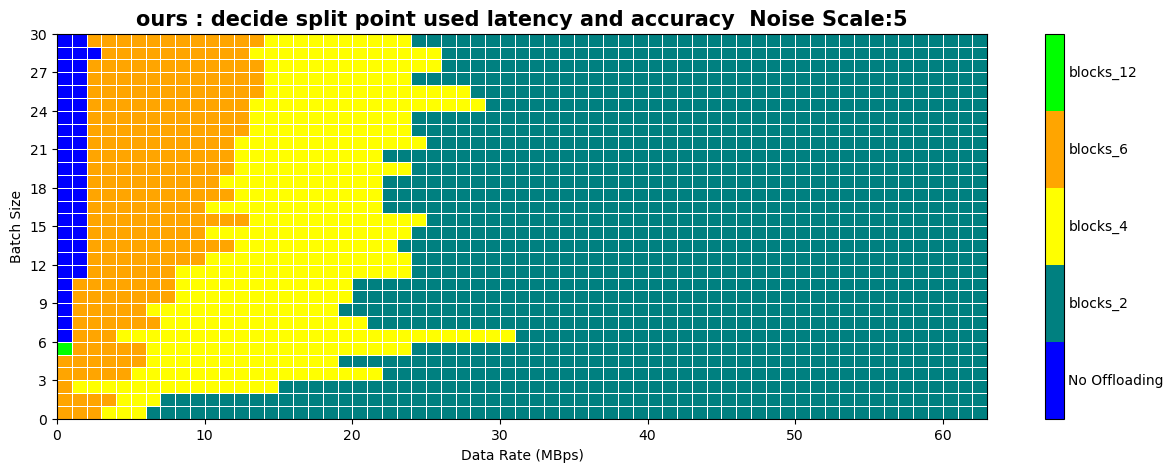

baseline


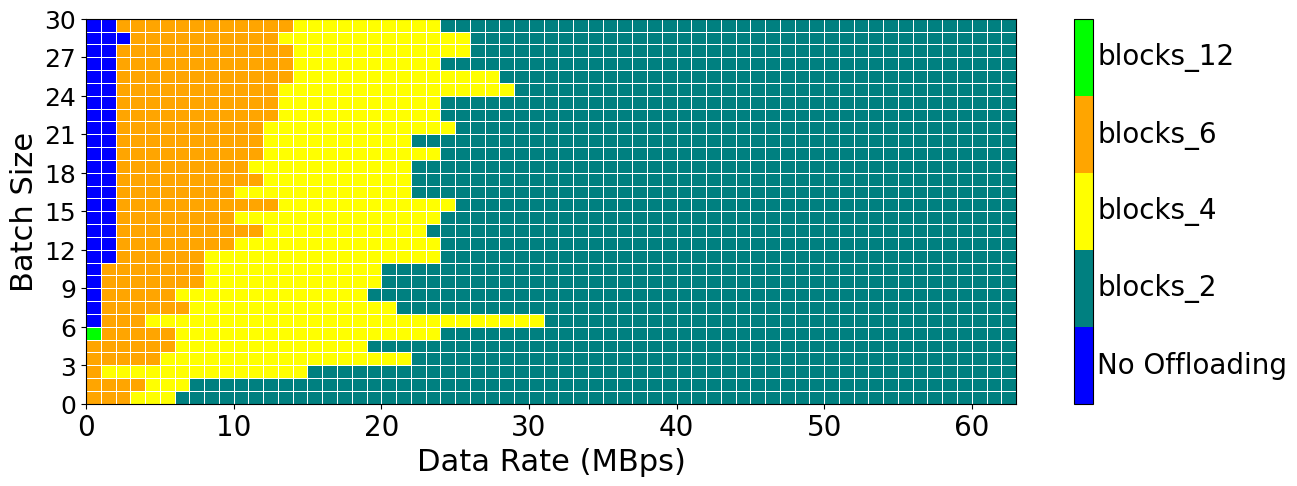

In [66]:
create_inference_plots(batch_table,config,acc1_list,acc1_baseline,save_flag=False)

In [57]:
# original_stdout = sys.stdout
# with open(f'{config["save_dir"]}/output_dsc.txt', 'w') as f:
#     sys.stdout = f
#     print('natural_bottlenecks')
#     for natural_bottleneck in natural_bottlenecks:
#         print(natural_bottleneck)
#     print(f'acc1_baseline : {acc1_baseline}')
#     print(f'acc1_list : {acc1_list}')
#     print('Difference from baseline : ', end='')
#     print([0]+[round(acc1_baseline - acc1,3) for acc1 in acc1_list])

#     acc1_diff_baseline_ratio =  [0]+[round((acc1_baseline - acc1) / acc1_baseline,5) for acc1 in acc1_list]
#     print('Difference ratio[(acc1_baseline - acc1) / acc1_baseline] :')
#     print(acc1_diff_baseline_ratio)
    
# sys.stdout = original_stdout

In [58]:
print("Experiment done")
print(datetime.datetime.now().strftime('%Y-%m%d_%H:%M:%S'))

Experiment done
2024-1214_22:52:28
